In [2]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_community langchain_core tavily-python langchain_nvidia_ai_endpoints

In [3]:
!pip install -U -q "google-genai>=1.16.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.6/222.6 kB 5.9 MB/s eta 0:00:00


In [4]:
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

In [5]:
from google import genai
from google.genai import types

client = genai.Client(api_key=GOOGLE_API_KEY)

In [6]:
# from typing_extensions import TypedDict
# from typing import  Annotated, List, Optional, Literal
# from pydantic import BaseModel, Field
# from pydantic.fields import FieldInfo
# import operator
# class OutputState(TypedDict):
#   genre:str
#   synopsis:str
#   theme: str
#   title: str
#   protoganist: str
#   tone: str

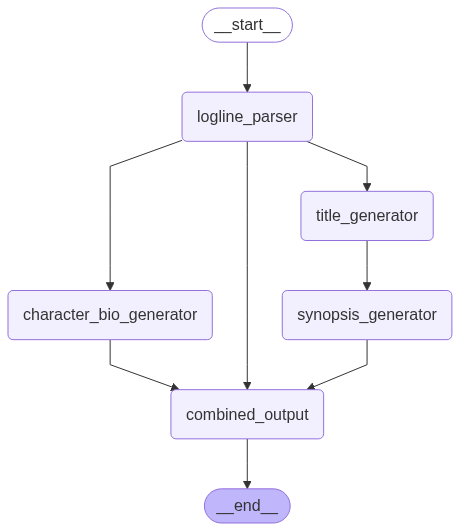

{'logline': 'A young wizard must find a magical artifact to save his world from an evil sorcerer.', 'logline_response': '```json\n{\n  "genre": "Fantasy",\n  "themes": [\n    "Good vs. Evil",\n    "Hero\'s Journey",\n    "Quest",\n    "Responsibility"\n  ],\n  "protagonist": "A young wizard",\n  "conflict": "The young wizard must find a magical artifact to save his world from an evil sorcerer.",\n  "tone": "Epic Fantasy Adventure"\n}\n```', 'title_response': 'The Arcanum Key', 'synopsis_response': "Elias, a young wizard whose days are typically filled with dusty scrolls and minor charms, finds his quiet life shattered when the malevolent sorcerer, Morwen, unleashes an ancient darkness across the realm of Eldoria. Cities fall, magic wanes, and hope dwindles as Morwen's shadow consumes the land. An ancient prophecy speaks of The Arcanum Key, a legendary artifact capable of sealing Morwen's power forever, and Elias, despite his inexperience and the weight of immense responsibility, is thr

In [7]:
from langchain.prompts import PromptTemplate
from google import genai
from google.genai import types
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from typing_extensions import TypedDict
from typing import  Annotated, List, Optional, Literal
from pydantic import BaseModel, Field
from pydantic.fields import FieldInfo
import operator

class GraphState(TypedDict):
  logline: str
  logline_response: str
  title_response: str
  synopsis_response: str
  character_bio_response: str

logline_parser_template = PromptTemplate(
  input_variables=["logline"],
  template=(
    "Role: You are a professional script development assistant.\n"
    "Task: Parse the following logline into its core elements.\n"
    "Logline: {logline}\n"
    "Format Constraints: Respond ONLY in JSON format with keys: genre, themes, protagonist, conflict, tone.\n"
    "Output Style: Clean, concise, and actionable."
  )
)

title_generator_template = PromptTemplate(
    input_variables=["parsed_logline"],
    template=(
        "Role: You are a script marketer.\n"
        "Task: Generate a compelling and memorable title for the script based on the parsed logline below.\n"
        "Parsed Logline: {parsed_logline}\n"
        "Format Constraints: Return a single title string.\n"
        "Output Style: Concise, attention-grabbing, genre-appropriate."
    )
)

synopsis_generator_template = PromptTemplate(
    input_variables=["parsed_logline", "title"],
    template=(
        "Role: You are an experienced screenwriter.\n"
        "Task: Write a 2–3 paragraph synopsis that captures beginning, middle, and end based on the parsed logline and title.\n"
        "Parsed Logline: {parsed_logline}\n"
        "Title: {title}\n"
        "Format Constraints: Output as plain text with paragraphs.\n"
        "Output Style: Insightful, emotionally engaging, concise."
    )
)

character_bio_template = PromptTemplate(
    input_variables=["parsed_logline"],
    template=(
        "Role: You are a character development specialist.\n"
        "Task: Generate detailed bios for the major characters implied by the logline.\n"
        "Parsed Logline: {parsed_logline}\n"
        "Format Constraints: Return a JSON array. Each entry must include: name, role, motivation, character arc, quirks.\n"
        "Output Style: Structured, clear, character-driven."
    )
)

def logline_parser(state: GraphState):
  logline_response = client.models.generate_content(model="gemini-2.5-flash",contents=[logline_parser_template.format(logline=state["logline"])])
  return {"logline_response": logline_response.text}

def title_generator(state: GraphState):
  parsed_logline = state['logline_response']
  title_response = client.models.generate_content(model="gemini-2.5-flash",contents=[title_generator_template.format(parsed_logline=parsed_logline)])
  return {"title_response": title_response.text}

def synopsis_generator(state: GraphState):
  parsed_logline = state['logline_response']
  title = state['title_response']
  synopsis_response = client.models.generate_content(model="gemini-2.5-flash",contents=[synopsis_generator_template.format(parsed_logline=parsed_logline, title=title)])
  return {"synopsis_response": synopsis_response.text}

def character_bio_generator(state: GraphState):
  parsed_logline = state['logline_response']
  character_bio_response = client.models.generate_content(model="gemini-2.5-flash",contents=[character_bio_template.format(parsed_logline=parsed_logline)])
  return {"character_bio_response": character_bio_response.text}

def combined_output(state: GraphState):
  return state

g = StateGraph(GraphState)
g.add_node("logline_parser",logline_parser)
g.add_node("title_generator",title_generator)
g.add_node("synopsis_generator",synopsis_generator)
g.add_node("character_bio_generator",character_bio_generator)
g.add_node("combined_output",combined_output)
g.add_edge(START, "logline_parser")
g.add_edge("logline_parser", "title_generator")
g.add_edge("logline_parser", "character_bio_generator")
g.add_edge("title_generator", "synopsis_generator")
g.add_edge("synopsis_generator", "combined_output")
g.add_edge("character_bio_generator", "combined_output")
g.add_edge("logline_parser", "combined_output")
g.add_edge("combined_output", END)


graph = g.compile()
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

# Sample logline and initial state
sample_logline = "A young wizard must find a magical artifact to save his world from an evil sorcerer."
initial_state = {"logline": sample_logline}

# Invoke the graph
output = graph.invoke(initial_state)
print(output)

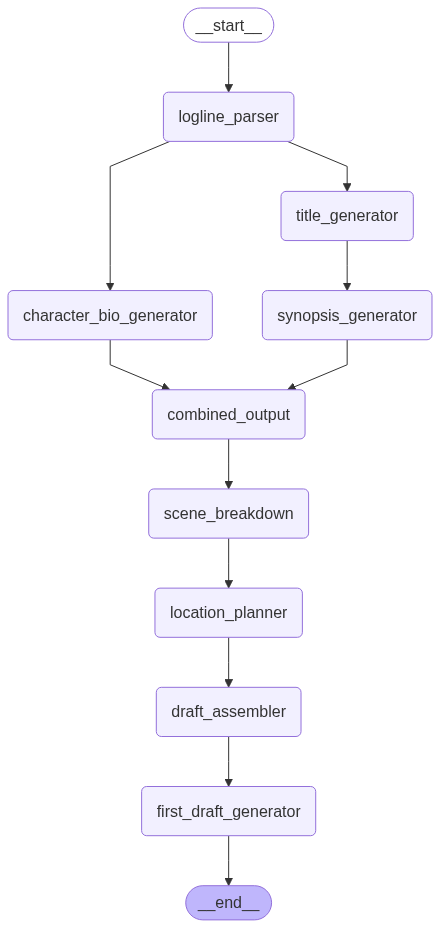

In [8]:
class GraphState(TypedDict):
  logline: str
  logline_response: str
  title_response: str
  synopsis_response: str
  character_bio_response: str
  scenebreakdown: str
  locations: str
  draft_skeleton: str
  first_draft: str

logline_parser_template = PromptTemplate(
  input_variables=["logline"],
  template=(
    "Role: You are a professional script development assistant.\n"
    "Task: Parse the following logline into its core elements.\n"
    "Logline: {logline}\n"
    "Format Constraints: Respond ONLY in JSON format with keys: genre, themes, protagonist, conflict, tone.\n"
    "Output Style: Clean, concise, and actionable."
  )
)

title_generator_template = PromptTemplate(
    input_variables=["parsed_logline"],
    template=(
        "Role: You are a script marketer.\n"
        "Task: Generate a compelling and memorable title for the script based on the parsed logline below.\n"
        "Parsed Logline: {parsed_logline}\n"
        "Format Constraints: Return a single title string.\n"
        "Output Style: Concise, attention-grabbing, genre-appropriate."
    )
)

synopsis_generator_template = PromptTemplate(
    input_variables=["parsed_logline", "title"],
    template=(
        "Role: You are an experienced screenwriter.\n"
        "Task: Write a 2–3 paragraph synopsis that captures beginning, middle, and end based on the parsed logline and title.\n"
        "Parsed Logline: {parsed_logline}\n"
        "Title: {title}\n"
        "Format Constraints: Output as plain text with paragraphs.\n"
        "Output Style: Insightful, emotionally engaging, concise."
    )
)

character_bio_template = PromptTemplate(
    input_variables=["parsed_logline"],
    template=(
        "Role: You are a character development specialist.\n"
        "Task: Generate detailed bios for the major characters implied by the logline.\n"
        "Parsed Logline: {parsed_logline}\n"
        "Format Constraints: Return a JSON array. Each entry must include: name, role, motivation, character arc, quirks.\n"
        "Output Style: Structured, clear, character-driven."
    )
)

def logline_parser(state: GraphState):
  logline_response = client.models.generate_content(model="gemini-2.5-flash",contents=[logline_parser_template.format(logline=state["logline"])])
  return {"logline_response": logline_response.text}

def title_generator(state: GraphState):
  parsed_logline = state['logline_response']
  title_response = client.models.generate_content(model="gemini-2.5-flash",contents=[title_generator_template.format(parsed_logline=parsed_logline)])
  return {"title_response": title_response.text}

def synopsis_generator(state: GraphState):
  parsed_logline = state['logline_response']
  title = state['title_response']
  synopsis_response = client.models.generate_content(model="gemini-2.5-flash",contents=[synopsis_generator_template.format(parsed_logline=parsed_logline, title=title)])
  return {"synopsis_response": synopsis_response.text}

def character_bio_generator(state: GraphState):
  parsed_logline = state['logline_response']
  character_bio_response = client.models.generate_content(model="gemini-2.5-flash",contents=[character_bio_template.format(parsed_logline=parsed_logline)])
  return {"character_bio_response": character_bio_response.text}

def combined_output(state: GraphState):
  return state

scenebreakdown_template = PromptTemplate(
  input_variables=["title", "synopsis", "character_bios"],
  template=(
    "Role: You are a story architect.\n"
    "Task: Break down the story with Title: {title}, Synopsis: {synopsis}, Characters: {character_bios} into 8–12 key scenes.\n"
    "Format Constraints: Return a JSON array of objects with keys: scene_no, goal, stakes, summary.\n"
    "Output Style: Strategic, storyflow-oriented, prioritized."
  )
)
locations_template = PromptTemplate(
  input_variables=["scenebreakdown"],
  template=(
    "Role: You are a cinematic setting designer.\n"
    "Task: For each scene in the breakdown below, suggest 1–2 evocative locations/settings.\n"
    "Scene Breakdown JSON: {scenebreakdown}\n"
    "Format Constraints: Return a JSON array of objects with keys: scene_no, location_description.\n"
    "Output Style: Vivid, visual, mood-enhancing."
  )
)

draft_assembler_template = PromptTemplate(
    input_variables=["title", "synopsis_response", "character_bio_response", "scenebreakdown", "locations"],
    template=(
        "Role: You are a script organizer.\n"
        "Task: Combine the provided story components into a structured draft skeleton to guide scriptwriting.\n\n"
        "Title: {title}\n"
        "Synopsis: {synopsis}\n"
        "Characters JSON: {characters}\n"
        "Scenes JSON: {scenes}\n"
        "Locations JSON: {locations}\n\n"
        "Format: Return a single JSON object with keys:\n"
        " - title\n - synopsis\n - characters (as array)\n - scenes (array of objects with: scene_no, summary, location)\n"
        "Output Style: Clean, structured, and parseable."
    )
)

first_draft_template = PromptTemplate(
    input_variables=["draft_skeleton"],
    template=(
        "Role: You are a professional scriptwriter.\n"
        "Task: For each scene in the story skeleton below, write detailed action lines and dialogue.\n\n"
        "Draft Skeleton JSON: {draft_skeleton}\n\n"
        "Format: Return a JSON array where each element includes:\n"
        "- scene_no\n- action_lines\n- dialogue_script\n\n"
        "Output Style: Cinematic, emotionally engaging, consistent with character bios and tone."
    )
)

def scene_breakdown(state: GraphState):
    resp = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=[scenebreakdown_template.format(
            title=state["title_response"],
            synopsis=state["synopsis_response"],
            character_bios=state["character_bio_response"]
        )]
    ).text
    return {"scenebreakdown": resp}

def location_planner(state: GraphState):
    resp = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=[locations_template.format(
            scenebreakdown=state["scenebreakdown"]
        )]
    ).text
    return {"locations": resp}

def draft_assembler(state: GraphState):
    resp = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=[
            draft_assembler_template.format(
                title=state["title_response"],
                synopsis=state["synopsis_response"],
                characters=state["character_bio_response"],
                scenes=state["scenebreakdown"],
                locations=state["locations"]
            )
        ]
    ).text
    return {"draft_skeleton": resp}

def first_draft_generator(state: GraphState):
    resp = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=[first_draft_template.format(
            draft_skeleton=state["draft_skeleton"]
        )]
    ).text
    return {"first_draft": resp}

g = StateGraph(GraphState)
g.add_node("logline_parser",logline_parser)
g.add_node("title_generator",title_generator)
g.add_node("synopsis_generator",synopsis_generator)
g.add_node("character_bio_generator",character_bio_generator)
g.add_node("combined_output",combined_output)
g.add_node("scene_breakdown",scene_breakdown)
g.add_node("location_planner",location_planner)
g.add_node("draft_assembler",draft_assembler)
g.add_node("first_draft_generator", first_draft_generator)

g.add_edge(START, "logline_parser")
g.add_edge("logline_parser", "title_generator")
g.add_edge("logline_parser", "character_bio_generator")
g.add_edge("title_generator", "synopsis_generator")
g.add_edge("synopsis_generator", "combined_output")
g.add_edge("character_bio_generator", "combined_output")
# g.add_edge("logline_parser", "combined_output")
g.add_edge("combined_output", "scene_breakdown")
g.add_edge("scene_breakdown", "location_planner")
g.add_edge("location_planner", "draft_assembler")
g.add_edge("draft_assembler", "first_draft_generator")
g.add_edge("first_draft_generator", END)
graph = g.compile()
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [11]:
result = graph.invoke({"logline": "A young wizard must find a magical artifact to save his world from an evil sorcerer."})
print(result["first_draft"])

```json
[
  {
    "scene_no": 1,
    "action_lines": "EXT. HIDDEN GROVE SANCTUARY - DAY\n\nThe air hangs heavy with the scent of dew-kissed earth and blooming wildflowers. Sunlight, filtered through the thick canopy of ancient, gnarled trees, paints shifting patterns on the moss-covered ground. It's a place of profound peace, almost ethereal.\n\nKAELEN VARRICK (20s, a kind face, a mop of unruly hair, dressed in simple, worn robes) sits cross-legged beside a babbling brook. He holds a smooth, river-worn STONE in his palm, tracing its contours with a thoughtful frown. Beside him, leaning against a centuries-old oak, is his GNARLED STAFF, WHISPER, which seems to faintly hum.\n\nKaelen tries to levitate the stone. It quivers, rising a mere inch before dropping back into his hand with a soft splash. He sighs, a small, frustrated MUMBLED sound.\n\nKAELEN\n(To the stone, then to Whisper)\nJust a little higher, little friend. We're getting there. Slowly. Like, *really* slowly. Maybe I should t

In [9]:
result = graph.invoke({"logline": "A young genius prodigy intrested in robotics tries to be a superhero and when an evil strikes,he fights it along with his friends and saves the city."})
print(result["first_draft"])

```json
[
  {
    "scene_no": 1,
    "action_lines": "FADE IN:\n\nINT. UNIVERSITY R&D HUB - DAY\n\nSunlight streams through the vast, multi-level glass walls of a cutting-edge university research and development hub. It's a marvel of 'Silicon Valley' architecture, with a central atrium allowing glimpses into various specialized labs.\n\nDown a flight of stairs, in a sprawling, chaotic yet organized robotics haven, ELIJAH \"ELI\" VANCE (20s, brilliant, perpetually messy lab coat stained with coffee, fidgeting with a custom multi-tool) is deep in concentration. Whirring servos and the gentle hum of power emanate from a complex PROTOTYPE DRONE, suspended mid-air by holographic displays.\n\nELI (V.O.)\n(Muttering)\n…optimal thruster vectoring at twenty-three degrees, accounting for atmospheric pressure differentials. Standard aerodynamic equations are so… limiting. Aren't they, little guy?\n\nEli adjusts a microscopic component with the precision of a surgeon, his brow furrowed in intense 